## Stacked Convolutional and Recurrent Neural Networks

In [1]:
import os
os.environ["PYTHONHASHSEED"] = "0"

import random as rn
rn.seed(1254)

import numpy as np
np.random.seed(1515)

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import librosa, librosa.display, IPython.display as ipd
from tqdm import tqdm
import glob
import pandas as pd
import h5py
from sklearn import preprocessing
import pickle

In [2]:
plt.rcParams['figure.figsize'] = (14, 6)

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf
tf.set_random_seed(2)

config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1 
)

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(graph= tf.get_default_graph(), config=config) 
    
import keras 
from keras import backend as K
K.set_session(sess)  # set this TensorFlow session as the default session for Keras

from keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Reshape
from keras.layers.wrappers import TimeDistributed
from keras.layers import Dense, Flatten
from keras.layers.core import Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [4]:
#SET PATHS
workspace = '/vol/vssp/AcousticEventsDetection/DLGdansk/UrbanSound/'

hdf5_path = os.path.join(workspace,'dataset.hdf5') 
modelfolder = os.path.join(workspace,'models')
scalerpath = os.path.join(workspace,'scaler.pkl')

In [5]:
# LOAD DATA
hf = h5py.File(hdf5_path, 'r')
X_train = np.array(hf.get('X_train') )
y_train = np.array(hf.get('y_train'))
X_val =  np.array(hf.get('X_val'))
y_val= np.array(hf.get('y_val'))
X_test = np.array(hf.get('X_test'))
y_test = np.array(hf.get('y_test'))

n_features= hf.get('n_features').value
n_frames=hf.get('max_length_samp').value
label_list= hf.get('label_list').value

In [6]:
# SCALE THE DATA
scaler=pickle.load(open(scalerpath, 'rb'))

X_train_scaled = [scaler.transform(x.T) for x in X_train]
X_val_scaled = [scaler.transform(x.T) for x in X_val]
X_test_scaled = [scaler.transform(x.T) for x in X_test]

# CHANGE DIMENSION TO FIT KERAS
X_train = np.expand_dims(X_train_scaled, 3)
X_val = np.expand_dims(X_val_scaled, 3)
X_test = np.expand_dims(X_test_scaled, 3)

In [7]:
def build_crnn(n_features=n_features, n_frames=n_frames, n_filters_cnn=48,
                     filter_size_cnn=(3, 3), pool_size=(2,2),
                     n_classes=10):

    # INPUT
    x = Input(shape=( n_frames, n_features, 1), dtype='float32')

    # CONV 1
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid', 
               kernel_regularizer=l2(0.01), activation='relu')(x)
    y = MaxPooling2D(pool_size=pool_size, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    # CONV 2
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid',
               kernel_regularizer=l2(0.01), activation='relu')(y)
    y = MaxPooling2D(pool_size=pool_size, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    # CONV 3
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid',
               kernel_regularizer=l2(0.01), activation='relu')(y)
    y = MaxPooling2D(pool_size=pool_size, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)
    
    y = TimeDistributed(Flatten())(y)
          
    y = Dropout(0.5)(y)
    y = LSTM(120)(y)

    y = Dropout(0.5)(y)
    y = Dense(n_classes, activation='sigmoid')(y)

    m = Model(inputs=x, outputs=y)
    return m

In [8]:
m = build_crnn(n_features=40,)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 173, 40, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 171, 38, 48)       480       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 19, 48)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 85, 19, 48)        192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 83, 17, 48)        20784     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 41, 8, 48)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 41, 8, 48)         192       
__________

In [9]:
from keras.utils import plot_model
plot_model(m, to_file='figures/crnn_model_shape.png', show_shapes=True)

<img src='figures/crnn_model_shape.png'>

In [10]:
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_checkpoint = ModelCheckpoint(
                os.path.join(modelfolder, 
                        'crnn_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.hdf5'),
                monitor='val_loss', 
                save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
callbacks = [early_stopping, model_checkpoint]

In [11]:
history = m.fit(x=X_train, y=y_train, batch_size=130,
                    epochs=200, verbose=True,
                    validation_split=0.0,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val), shuffle=True)

Train on 7079 samples, validate on 7079 samples
Epoch 1/200
7079/7079 [==============================] - 12s 2ms/step - loss: 2.6454 - acc: 0.3238 - val_loss: 3.0212 - val_acc: 0.1521
Epoch 2/200
7079/7079 [==============================] - 9s 1ms/step - loss: 1.9299 - acc: 0.4802 - val_loss: 3.4704 - val_acc: 0.1170
Epoch 3/200
7079/7079 [==============================] - 9s 1ms/step - loss: 1.4921 - acc: 0.6168 - val_loss: 4.2824 - val_acc: 0.1161
Epoch 4/200
7079/7079 [==============================] - 9s 1ms/step - loss: 1.2057 - acc: 0.6964 - val_loss: 3.9733 - val_acc: 0.1835
Epoch 5/200
7079/7079 [==============================] - 9s 1ms/step - loss: 0.9979 - acc: 0.7604 - val_loss: 4.8344 - val_acc: 0.1177
Epoch 6/200
7079/7079 [==============================] - 9s 1ms/step - loss: 0.8429 - acc: 0.8076 - val_loss: 4.1130 - val_acc: 0.1879
Epoch 7/200
7079/7079 [==============================] - 9s 1ms/step - loss: 0.7370 - acc: 0.8387 - val_loss: 3.6630 - val_acc: 0.2434
Epoch 

Epoch 61/200
7079/7079 [==============================] - 9s 1ms/step - loss: 0.2112 - acc: 0.9722 - val_loss: 0.1833 - val_acc: 0.9805
Epoch 62/200
7079/7079 [==============================] - 8s 1ms/step - loss: 0.2220 - acc: 0.9702 - val_loss: 0.1626 - val_acc: 0.9866
Epoch 63/200
7079/7079 [==============================] - 8s 1ms/step - loss: 0.2079 - acc: 0.9715 - val_loss: 0.1648 - val_acc: 0.9839
Epoch 64/200
7079/7079 [==============================] - 8s 1ms/step - loss: 0.2202 - acc: 0.9695 - val_loss: 0.1697 - val_acc: 0.9836
Epoch 65/200
7079/7079 [==============================] - 9s 1ms/step - loss: 0.2228 - acc: 0.9677 - val_loss: 0.1883 - val_acc: 0.9733
Epoch 66/200
7079/7079 [==============================] - 8s 1ms/step - loss: 0.2371 - acc: 0.9681 - val_loss: 0.1922 - val_acc: 0.9818
Epoch 67/200
7079/7079 [==============================] - 8s 1ms/step - loss: 0.2117 - acc: 0.9761 - val_loss: 0.1664 - val_acc: 0.9840
Epoch 68/200
7079/7079 [========================

7079/7079 [==============================] - 9s 1ms/step - loss: 0.1707 - acc: 0.9819 - val_loss: 0.1242 - val_acc: 0.9953
Epoch 122/200
7079/7079 [==============================] - 9s 1ms/step - loss: 0.1814 - acc: 0.9788 - val_loss: 0.1309 - val_acc: 0.9924
Epoch 123/200
7079/7079 [==============================] - 9s 1ms/step - loss: 0.1573 - acc: 0.9853 - val_loss: 0.1594 - val_acc: 0.9828
Epoch 124/200
7079/7079 [==============================] - 9s 1ms/step - loss: 0.1720 - acc: 0.9805 - val_loss: 0.1178 - val_acc: 0.9942
Epoch 125/200
7079/7079 [==============================] - 9s 1ms/step - loss: 0.1612 - acc: 0.9814 - val_loss: 0.1585 - val_acc: 0.9811
Epoch 126/200
7079/7079 [==============================] - 9s 1ms/step - loss: 0.1645 - acc: 0.9801 - val_loss: 0.1228 - val_acc: 0.9917
Epoch 127/200
7079/7079 [==============================] - 9s 1ms/step - loss: 0.1583 - acc: 0.9832 - val_loss: 0.1360 - val_acc: 0.9895
Epoch 128/200
7079/7079 [==============================

Epoch 181/200
7079/7079 [==============================] - 8s 1ms/step - loss: 0.1374 - acc: 0.9853 - val_loss: 0.1044 - val_acc: 0.9952
Epoch 182/200
7079/7079 [==============================] - 8s 1ms/step - loss: 0.1293 - acc: 0.9869 - val_loss: 0.0982 - val_acc: 0.9963
Epoch 183/200
7079/7079 [==============================] - 8s 1ms/step - loss: 0.1320 - acc: 0.9862 - val_loss: 0.0998 - val_acc: 0.9952
Epoch 184/200
7079/7079 [==============================] - 9s 1ms/step - loss: 0.1362 - acc: 0.9835 - val_loss: 0.1791 - val_acc: 0.9751
Epoch 185/200
7079/7079 [==============================] - 9s 1ms/step - loss: 0.1603 - acc: 0.9797 - val_loss: 0.1048 - val_acc: 0.9956
Epoch 186/200
7079/7079 [==============================] - 8s 1ms/step - loss: 0.1339 - acc: 0.9867 - val_loss: 0.1690 - val_acc: 0.9808
Epoch 187/200
7079/7079 [==============================] - 8s 1ms/step - loss: 0.1586 - acc: 0.9794 - val_loss: 0.1251 - val_acc: 0.9895
Epoch 188/200
7079/7079 [================

Text(0,0.5,u'Loss')

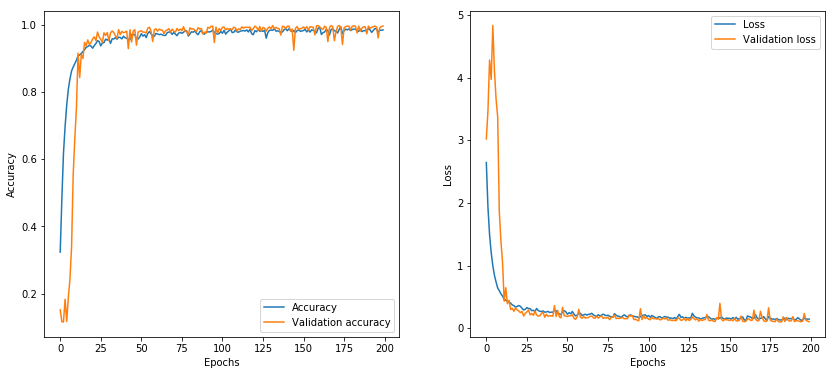

In [12]:
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='Accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [13]:
prediction = m.predict(X_test, batch_size=130, verbose=1)
y_predict=np.array([ np.argmax(p) for p in prediction])
y_test_label = np.array([np.argmax(y) for y in y_test])

837/837 [==============================] - 0s 555us/step


Accuracy: 0.75


Text(0.5,32.0938,u'Predicted label')

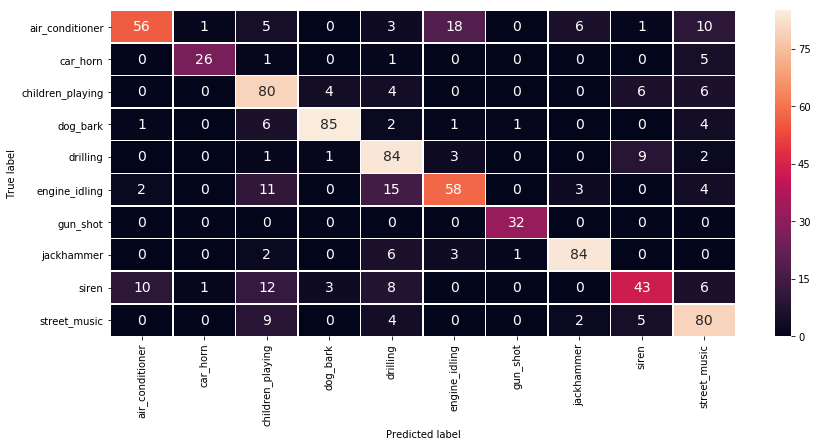

In [14]:
from sklearn.metrics import confusion_matrix

acc = np.sum(y_test_label==y_predict) / float(len(y_test_label))
print('Accuracy: {:.2f}'.format(acc))

cm = confusion_matrix(y_test_label, y_predict )
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, 
            yticklabels=label_list,xticklabels=label_list)
plt.ylabel('True label')
plt.xlabel('Predicted label')

#### Final results

|              | CNN           | RNN  | CRNN |
| ------------- |:-------------:| -----:| -----:|
| Accuracy     | 73% | 55% | 75% | 

+ seems that CRNN are doing a good job
+ but proper statistical analysis would be needed to really be able to say that